In [1]:
import pandas as pd
import numpy as np

### 第一部分：计算因子，并将它们进行行业/市值/动量中性化

In [2]:
df_industry = pd.read_parquet('rawdata/industry.parquet')

In [6]:
df_factor = pd.read_parquet('eps_rawdata.parquet')

In [7]:
df_factor = df_factor[['order_book_id','quarter','info_date','adj_net_profit']]

df_factor = df_factor.sort_values(['info_date','order_book_id'])
df_industry = df_industry.sort_values(['date','order_book_id'])
df_factor = pd.merge_asof(df_industry,df_factor, left_on=['date'],right_on=['info_date'],by=['order_book_id'],direction='backward')

In [8]:
df_market = pd.read_parquet('rawdata/processed_market_data.parquet')
df_factor = pd.merge(df_factor,df_market,on=['order_book_id','date'])

In [9]:
df_factor['RPE'] = df_factor['adj_net_profit']/df_factor['total_a']/df_factor['close']

In [10]:
# 每日每股的行业分组和每股RPE
df_factor

,order_book_id,first_industry_code,date,quarter,info_date,adj_net_profit,adj_close,adj_factor,adj_high,adj_low,...,total_turnover,turnover_rate,volume,st_change,halt_change,day_count,ret_overnight,ret_day,ret_daily,RPE
0,000001,40,2016-01-04,2015q3,2015-10-23,6.155000e+09,7.631433,1.484649,8.102925,7.564077,...,6.603762e+08,0.004774,56349787.0,False,False,489,-0.005296,0.011535,0.006239,0.037966
1,000004,35,2016-01-04,2015q3,2015-10-31,3.031473e+06,41.310000,1.000000,46.600000,41.310000,...,9.767487e+07,0.027223,2283380.0,False,False,480,-0.092229,0.031467,-0.060763,0.000874
2,000005,42,2016-01-04,2015q3,2015-10-30,-6.647514e+06,9.040000,1.000000,10.000000,9.040000,...,3.022410e+08,0.035394,32340643.0,False,False,390,-0.097345,0.090686,-0.006659,-0.000695
3,000006,42,2016-01-04,2015q3,2015-10-28,1.921660e+07,8.336709,1.245096,9.252302,8.320646,...,2.546398e+08,0.017358,23285271.0,False,False,490,-0.070328,0.040415,-0.029913,0.001371
4,000008,26,2016-01-04,2015q3,2015-10-31,2.561229e+07,10.427593,1.017493,11.675759,10.417765,...,1.570146e+08,0.021913,14039993.0,False,False,325,-0.086711,0.115583,0.028872,0.001002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8184301,688799,35,2024-11-18,2024q3,2024-10-29,3.987200e+07,39.840000,1.000000,40.980000,39.600000,...,4.225785e+07,0.011193,1049896.0,False,False,812,0.003765,0.011753,0.015518,0.010670
8184302,688800,60,2024-11-18,2024q3,2024-10-25,4.060403e+07,37.080000,1.000000,38.580000,36.710000,...,1.491871e+08,0.025215,3994572.0,False,False,805,0.006742,0.047415,0.054157,0.006912
8184303,688819,27,2024-11-18,2024q3,2024-10-30,2.957513e+08,29.870000,1.000000,30.600000,29.650000,...,9.441172e+07,0.003226,3135956.0,False,False,928,0.009039,0.015926,0.024965,0.010185
8184304,688981,60,2024-11-18,2024q2,2024-08-30,1.191788e+09,92.300000,1.000000,97.500000,91.370000,...,7.818658e+09,0.041691,82897403.0,False,False,1053,-0.002167,0.030402,0.028235,0.006494


In [11]:
# 每日每个行业的RPE中位数
result = df_factor.groupby(['first_industry_code', 'date']).agg( RPE_related_median=('RPE', 'median'),
                                               RPE_related_std=('RPE', 'std') ) 

result = result.reset_index()

In [12]:
result

,first_industry_code,date,RPE_related_median,RPE_related_std
0,10,2016-01-04,0.001045,0.010591
1,10,2016-01-05,0.001084,0.010761
2,10,2016-01-06,0.001022,0.010435
3,10,2016-01-07,0.001135,0.011531
4,10,2016-01-08,0.001132,0.011361
...,...,...,...,...
63722,70,2024-11-12,0.000889,0.017428
63723,70,2024-11-13,0.000904,0.017630
63724,70,2024-11-14,0.000921,0.018312
63725,70,2024-11-15,0.000937,0.019142


In [13]:
df = pd.merge(df_factor,result,on=['first_industry_code','date'],how='outer')
df

,order_book_id,first_industry_code,date,quarter,info_date,adj_net_profit,adj_close,adj_factor,adj_high,adj_low,...,volume,st_change,halt_change,day_count,ret_overnight,ret_day,ret_daily,RPE,RPE_related_median,RPE_related_std
0,000001,40,2016-01-04,2015q3,2015-10-23,6.155000e+09,7.631433,1.484649,8.102925,7.564077,...,56349787.0,False,False,489,-0.005296,0.011535,0.006239,0.037966,0.043998,0.267502
1,002142,40,2016-01-04,2015q3,2015-10-30,1.776651e+09,8.811288,1.633132,9.539949,8.792918,...,31961800.0,False,False,489,-0.013899,0.027484,0.013586,0.031659,0.043998,0.267502
2,600000,40,2016-01-04,2015q3,2015-10-30,1.334900e+10,9.039665,1.969099,9.283431,8.912704,...,42240610.0,False,False,475,-0.016292,0.025700,0.009407,0.040204,0.043998,0.267502
3,600015,40,2016-01-04,2015q3,2015-10-31,4.668000e+09,6.515654,1.754237,6.863383,6.498552,...,40111596.0,False,False,490,-0.018373,0.024064,0.005691,0.038220,0.043998,0.267502
4,600016,40,2016-01-04,2015q3,2015-10-31,1.179100e+10,4.780447,1.888945,5.055733,4.769859,...,83867659.0,False,False,490,-0.008859,0.018994,0.010135,0.044185,0.043998,0.267502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8184301,603958,34,2024-11-18,2024q3,2024-10-30,-2.928656e+07,12.300000,1.000000,13.300000,12.150000,...,12830400.0,False,False,2023,0.000000,0.030894,0.030894,-0.010854,0.006183,0.014353
8184302,605003,34,2024-11-18,2024q3,2024-10-24,2.074705e+07,18.080000,1.000000,19.470000,17.800000,...,2597599.0,False,False,1015,0.000000,0.045354,0.045354,0.010432,0.006183,0.014353
8184303,605055,34,2024-11-18,2024q3,2024-10-31,-4.861121e+05,5.160000,1.000000,5.350000,5.100000,...,5021600.0,False,False,919,0.000000,0.005814,0.005814,-0.000214,0.006183,0.014353
8184304,605138,34,2024-11-18,2024q3,2024-10-29,9.477090e+06,5.550000,1.000000,5.660000,5.460000,...,3214900.0,False,False,743,0.012613,0.010676,0.023289,0.003074,0.006183,0.014353


In [15]:
from backtesting import process_factors,neutralize_factors,calculate_and_plot_ic,calculate_benchmark_return,custom_quantile_grouping,get_pnl,plot_cumulative_returns,calculate_annual_metrics

In [16]:
# 假设一年是250个交易日

df['RPE_mean'] = df.groupby('order_book_id')['RPE'].rolling(250).mean().reset_index(0,drop=True)
df['RPE_std'] = df.groupby('order_book_id')['RPE'].rolling(250).std().reset_index(0,drop=True)
df['RPE_zscore'] = (df['RPE']-df['RPE_mean'])/df['RPE_std']

df['DST'] = df['RPE'] - df['RPE_related_median']
df['PRM'] = df['DST'] / df['RPE_related_std']


df['DST_mean'] = df.groupby('order_book_id')['DST'].rolling(250).mean().reset_index(0,drop=True)
df['DST_std'] = df.groupby('order_book_id')['DST'].rolling(250).std().reset_index(0,drop=True)
df['DST_zscore'] = (df['DST']-df['DST_mean'])/df['DST_std']

df['PRM_mean'] = df.groupby('order_book_id')['PRM'].rolling(250).mean().reset_index(0,drop=True)
df['PRM_std'] = df.groupby('order_book_id')['PRM'].rolling(250).std().reset_index(0,drop=True)
df['PRM_zscore'] = (df['PRM']-df['PRM_mean'])/df['PRM_std']


In [17]:
df_market = pd.read_parquet('rawdata/processed_market_data.parquet')

df_industry = pd.read_parquet('rawdata/industry.parquet')
df_industry['order_book_id'] = df_industry['order_book_id'].str[:6]

df_industry = pd.merge(df_market[['order_book_id','date']], df_industry, how = 'left')
df_industry['first_industry_code'] = df_industry['first_industry_code'].ffill()
df_industry.dropna(inplace=True)

df_industry = pd.get_dummies(df_industry, columns = ['first_industry_code'],prefix='industry')
df_industry = df_industry.astype({col: 'int' for col in df_industry.columns if col.startswith('industry_')})

In [18]:
df = process_factors(df,factors= ['RPE'],process_method='rank')
df = neutralize_factors(df, factors=  ['RPE'], market_factor=False,momentum_factor=False, industry_factor=True, df_industry = df_industry)
df = df.drop(['industry_10', 'industry_11', 'industry_12',
       'industry_20', 'industry_21', 'industry_22', 'industry_23',
       'industry_24', 'industry_25', 'industry_26', 'industry_27',
       'industry_28', 'industry_30', 'industry_31', 'industry_32',
       'industry_33', 'industry_34', 'industry_35', 'industry_36',
       'industry_37', 'industry_40', 'industry_41', 'industry_42',
       'industry_43', 'industry_50', 'industry_60', 'industry_61',
       'industry_62', 'industry_63', 'industry_70'],axis=1)


yes,it is rank
Finish neutralize


In [19]:
df

,order_book_id,first_industry_code,date,quarter,info_date,adj_net_profit,adj_close,adj_factor,adj_high,adj_low,...,DST,PRM,DST_mean,DST_std,DST_zscore,PRM_mean,PRM_std,PRM_zscore,RPE_process,neu_RPE_process
0,000001,40,2016-01-04,2015q3,2015-10-23,6.155000e+09,7.631433,1.484649,8.102925,7.564077,...,-0.006032,-0.022548,NaN,NaN,NaN,NaN,NaN,NaN,2441.0,2.5000
1,002142,40,2016-01-04,2015q3,2015-10-30,1.776651e+09,8.811288,1.633132,9.539949,8.792918,...,-0.012339,-0.046126,NaN,NaN,NaN,NaN,NaN,NaN,2426.0,-12.5000
2,600000,40,2016-01-04,2015q3,2015-10-30,1.334900e+10,9.039665,1.969099,9.283431,8.912704,...,-0.003794,-0.014183,NaN,NaN,NaN,NaN,NaN,NaN,2445.0,6.5000
3,600015,40,2016-01-04,2015q3,2015-10-31,4.668000e+09,6.515654,1.754237,6.863383,6.498552,...,-0.005778,-0.021601,NaN,NaN,NaN,NaN,NaN,NaN,2442.0,3.5000
4,600016,40,2016-01-04,2015q3,2015-10-31,1.179100e+10,4.780447,1.888945,5.055733,4.769859,...,0.000188,0.000701,NaN,NaN,NaN,NaN,NaN,NaN,2452.0,13.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8034145,603958,34,2024-11-18,2024q3,2024-10-30,-2.928656e+07,12.300000,1.000000,13.300000,12.150000,...,-0.017037,-1.187009,-0.009502,0.004404,-1.710824,-0.669454,0.224041,-2.310093,389.0,-2232.6875
8034146,605003,34,2024-11-18,2024q3,2024-10-24,2.074705e+07,18.080000,1.000000,19.470000,17.800000,...,0.004249,0.296069,0.001597,0.001147,2.312940,0.113017,0.083750,2.185701,3590.0,968.3125
8034147,605055,34,2024-11-18,2024q3,2024-10-31,-4.861121e+05,5.160000,1.000000,5.350000,5.100000,...,-0.006397,-0.445671,-0.005343,0.006527,-0.161459,-0.414484,0.446944,-0.069778,1272.0,-1349.6875
8034148,605138,34,2024-11-18,2024q3,2024-10-29,9.477090e+06,5.550000,1.000000,5.660000,5.460000,...,-0.003109,-0.216606,-0.007708,0.001943,2.366843,-0.577945,0.179538,2.012607,2089.0,-532.6875


In [21]:
df = df.rename(columns={'neu_RPE_process':'sector_neu'})
df['sector_neu_mean']= df.groupby('order_book_id')['sector_neu'].rolling(250).mean().reset_index(0,drop=True)
df['sector_neu_std'] = df.groupby('order_book_id')['sector_neu'].rolling(250).std().reset_index(0,drop=True)
df['sector_neu_zscore'] = (df['sector_neu']-df['sector_neu_mean'])/df['sector_neu_std']

In [22]:
df

,order_book_id,first_industry_code,date,quarter,info_date,adj_net_profit,adj_close,adj_factor,adj_high,adj_low,...,DST_std,DST_zscore,PRM_mean,PRM_std,PRM_zscore,RPE_process,sector_neu,sector_neu_mean,sector_neu_std,sector_neu_zscore
0,000001,40,2016-01-04,2015q3,2015-10-23,6.155000e+09,7.631433,1.484649,8.102925,7.564077,...,NaN,NaN,NaN,NaN,NaN,2441.0,2.5000,NaN,NaN,NaN
1,002142,40,2016-01-04,2015q3,2015-10-30,1.776651e+09,8.811288,1.633132,9.539949,8.792918,...,NaN,NaN,NaN,NaN,NaN,2426.0,-12.5000,NaN,NaN,NaN
2,600000,40,2016-01-04,2015q3,2015-10-30,1.334900e+10,9.039665,1.969099,9.283431,8.912704,...,NaN,NaN,NaN,NaN,NaN,2445.0,6.5000,NaN,NaN,NaN
3,600015,40,2016-01-04,2015q3,2015-10-31,4.668000e+09,6.515654,1.754237,6.863383,6.498552,...,NaN,NaN,NaN,NaN,NaN,2442.0,3.5000,NaN,NaN,NaN
4,600016,40,2016-01-04,2015q3,2015-10-31,1.179100e+10,4.780447,1.888945,5.055733,4.769859,...,NaN,NaN,NaN,NaN,NaN,2452.0,13.5000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8034145,603958,34,2024-11-18,2024q3,2024-10-30,-2.928656e+07,12.300000,1.000000,13.300000,12.150000,...,0.004404,-1.710824,-0.669454,0.224041,-2.310093,389.0,-2232.6875,-1525.541042,617.371810,-1.145414
8034146,605003,34,2024-11-18,2024q3,2024-10-24,2.074705e+07,18.080000,1.000000,19.470000,17.800000,...,0.001147,2.312940,0.113017,0.083750,2.185701,3590.0,968.3125,538.589817,287.035715,1.497105
8034147,605055,34,2024-11-18,2024q3,2024-10-31,-4.861121e+05,5.160000,1.000000,5.350000,5.100000,...,0.006527,-0.161459,-0.414484,0.446944,-0.069778,1272.0,-1349.6875,-784.894183,1094.773477,-0.515900
8034148,605138,34,2024-11-18,2024q3,2024-10-29,9.477090e+06,5.550000,1.000000,5.660000,5.460000,...,0.001943,2.366843,-0.577945,0.179538,2.012607,2089.0,-532.6875,-1357.982183,454.664879,1.815171


In [24]:
df = process_factors(df,factors= ['DST_zscore','sector_neu_zscore','RPE_zscore','DST','sector_neu'],process_method='rank')
df = neutralize_factors(df, factors=['DST_zscore','sector_neu_zscore','RPE_zscore','DST','sector_neu'], market_factor=True,momentum_factor=True, industry_factor=True,df_industry = df_industry)


df = df.drop(['industry_10', 'industry_11', 'industry_12',
       'industry_20', 'industry_21', 'industry_22', 'industry_23',
       'industry_24', 'industry_25', 'industry_26', 'industry_27',
       'industry_28', 'industry_30', 'industry_31', 'industry_32',
       'industry_33', 'industry_34', 'industry_35', 'industry_36',
       'industry_37', 'industry_40', 'industry_41', 'industry_42',
       'industry_43', 'industry_50', 'industry_60', 'industry_61',
       'industry_62', 'industry_63', 'industry_70'],axis=1)
df

yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
yes,it is rank
Finish neutralize


,order_book_id,first_industry_code,date,quarter,info_date,adj_net_profit,adj_close,adj_factor,adj_high,adj_low,...,RPE_zscore_process,DST_process,sector_neu_process,market_factor,momentum_factor,neu_DST_zscore_process,neu_sector_neu_zscore_process,neu_RPE_zscore_process,neu_DST_process,neu_sector_neu_process
0,000001,40,2017-01-10,2016q3,2016-10-21,6.427000e+09,7.505731,1.219069,7.513934,7.497528,...,778.0,233.0,1301.5,25.765397,0.026656,502.015625,132.062500,420.572266,-1041.000000,101.250000
1,600015,40,2017-01-10,2016q3,2016-10-31,4.811000e+09,6.547642,1.690685,6.571301,6.523983,...,178.0,218.0,1300.0,25.496399,0.126050,24.640625,25.812500,-167.175781,-954.500000,200.875000
2,600016,40,2017-01-10,2016q3,2016-10-29,1.218700e+10,4.971910,1.816203,4.982922,4.960898,...,488.0,1051.0,1306.0,26.309962,-0.011911,255.796875,10.593750,139.859375,-390.000000,-53.375000
3,600036,40,2017-01-10,2016q3,2016-10-29,1.701200e+10,13.254263,1.353527,13.365085,13.232099,...,532.0,1118.0,1308.5,26.636994,0.054246,311.609375,24.968750,208.158203,-402.250000,-121.375000
4,601009,40,2017-01-10,2016q3,2016-10-25,2.019657e+09,5.348533,2.088423,5.439511,5.338957,...,112.0,48.0,1261.0,24.888117,0.117774,-126.890625,-26.218750,-254.316406,-950.000000,325.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732706,603958,34,2024-11-18,2024q3,2024-10-30,-2.928656e+07,12.300000,1.000000,13.300000,12.150000,...,302.0,354.0,246.0,21.715824,0.271571,-2181.766788,-1741.022622,-1926.939529,-1884.163174,-1982.246661
6732707,605003,34,2024-11-18,2024q3,2024-10-24,2.074705e+07,18.080000,1.000000,19.470000,17.800000,...,2355.0,3463.0,3542.0,21.410797,0.120733,2001.232234,1419.700663,238.860484,1175.926615,1249.668635
6732708,605055,34,2024-11-18,2024q3,2024-10-31,-4.861121e+05,5.160000,1.000000,5.350000,5.100000,...,1838.0,1090.0,970.0,21.543222,0.088455,-374.740800,-922.589792,-257.591138,-1291.636442,-1417.957429
6732709,605138,34,2024-11-18,2024q3,2024-10-29,9.477090e+06,5.550000,1.000000,5.660000,5.460000,...,3708.0,1710.0,1803.0,21.849289,-0.029787,2122.753460,1676.383159,1690.932361,-941.883596,-861.076531


### 第二部分：两两进行互相中性化

#### DST 和 sec_neu

Finish neutralize


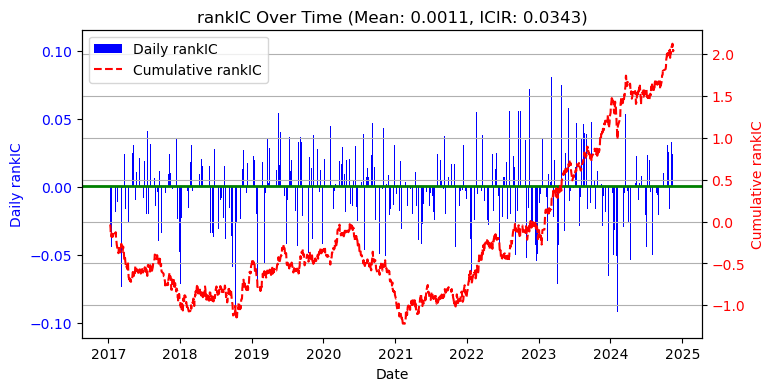

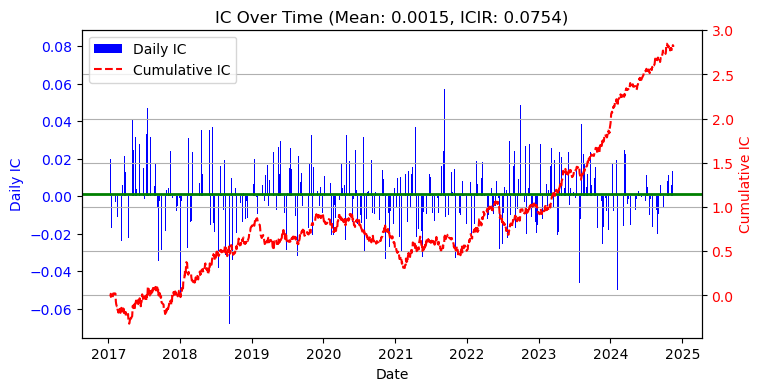

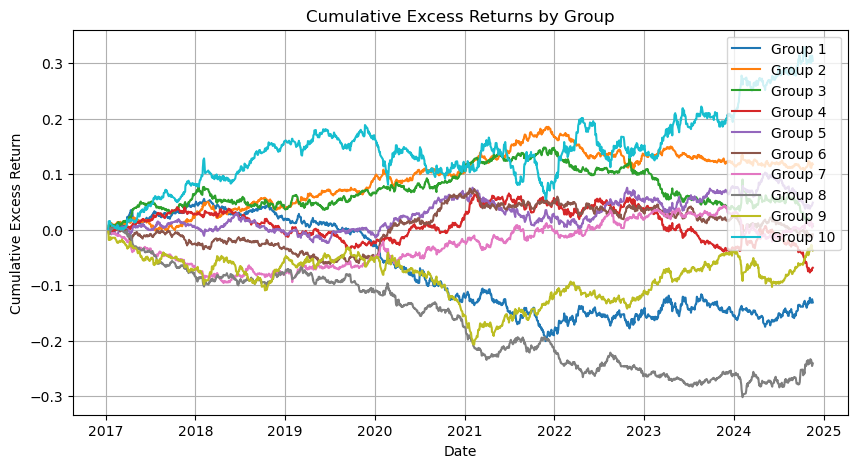

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.049865,-0.017213,-1.231594,-0.426293,0.108839
1,-0.072634,0.015469,-2.642531,0.565154,0.293677
2,-0.137526,0.000869,-4.088801,0.025967,0.461317
3,-0.184984,-0.009017,-5.199247,-0.254938,0.586558
4,-0.185007,0.006389,-5.556328,0.192730,0.637989
5,-0.182349,-0.001121,-5.857777,-0.036288,0.604095
6,-0.156250,0.001308,-4.990529,0.042407,0.525193
7,-0.165639,-0.031645,-4.990407,-0.964607,0.446645
8,-0.101566,-0.004936,-2.476827,-0.121133,0.322099


In [25]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_DST_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_sector_neu_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_DST_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_DST_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_DST_process'] = df1['neu_neu_DST_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_DST_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

Finish neutralize


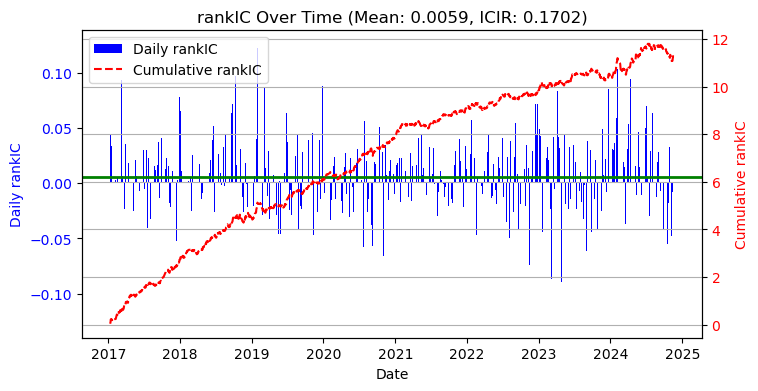

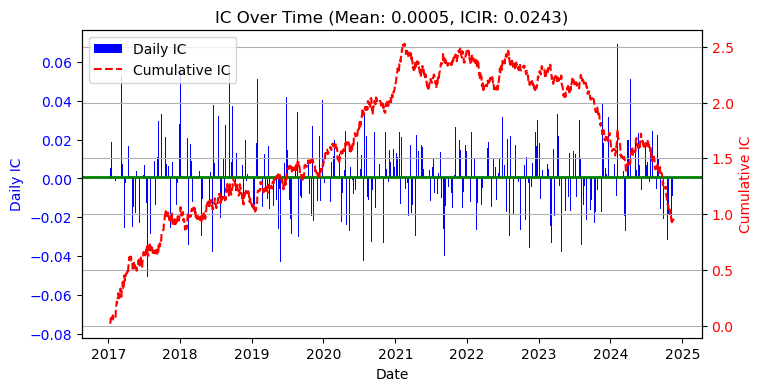

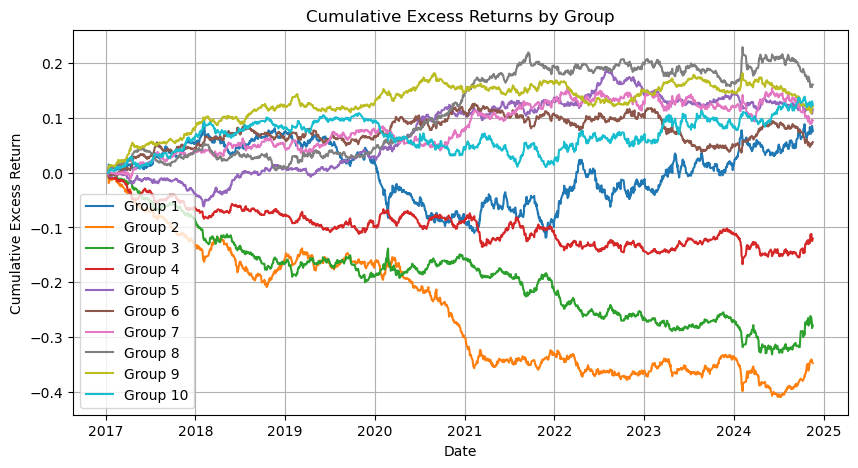

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.034142,0.009907,-0.611200,0.177592,0.146831
1,-0.144073,-0.045517,-3.570515,-1.137526,0.328519
2,-0.151761,-0.036531,-3.962036,-0.961569,0.384099
3,-0.139156,-0.015777,-4.124501,-0.472720,0.411263
4,-0.130648,0.015126,-4.374673,0.509150,0.485914
5,-0.164593,0.007285,-4.999030,0.222588,0.572927
6,-0.158250,0.012455,-4.413804,0.348066,0.569018
7,-0.115449,0.021021,-3.408241,0.623998,0.454900
8,-0.072317,0.015843,-2.588875,0.570216,0.293864


In [26]:
dftemp = df.copy()

dftemp = neutralize_factors(dftemp, factors=  ['neu_sector_neu_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False,other='neu_DST_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_sector_neu_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_sector_neu_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_sector_neu_process'] = df1['neu_neu_sector_neu_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_sector_neu_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))
calculate_annual_metrics(pnl_result)

#### DST_ZSCORE & sec_neu_zscore

Finish neutralize


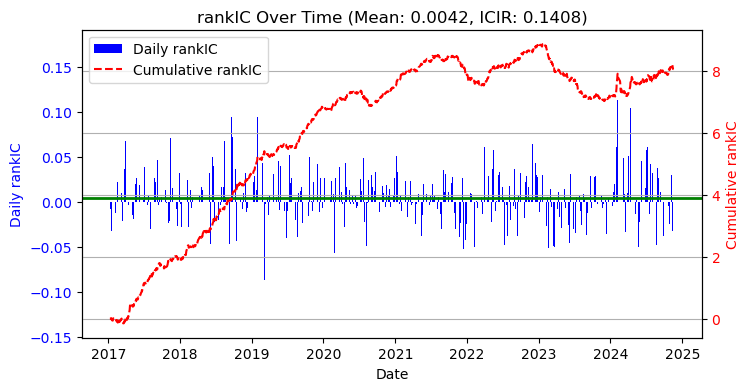

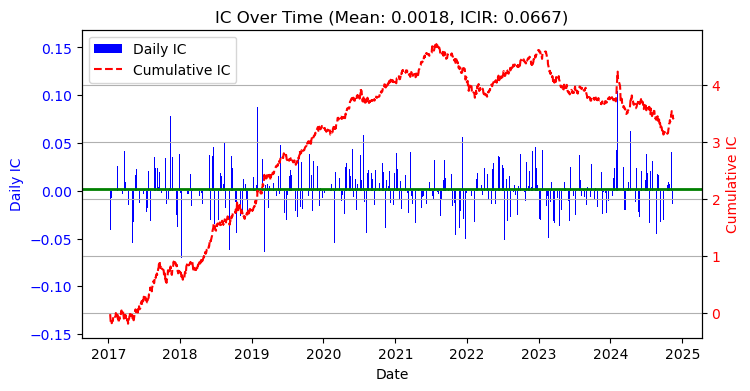

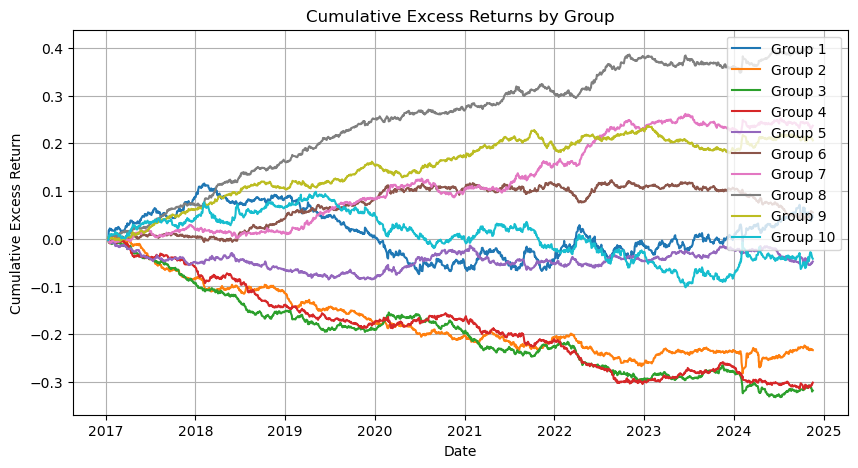

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.044847,0.005963,-1.051869,0.140229,0.169365
1,-0.156215,-0.030644,-5.609255,-1.109751,0.418570
2,-0.214738,-0.041734,-8.238356,-1.635616,0.576679
3,-0.238204,-0.039572,-9.176133,-1.565063,0.662107
4,-0.216192,-0.006270,-8.630441,-0.253760,0.699742
5,-0.203337,0.007229,-8.009515,0.289963,0.701886
6,-0.168686,0.031085,-6.617875,1.228672,0.665905
7,-0.122056,0.052460,-4.852848,2.096138,0.581720
8,-0.098194,0.027060,-4.044948,1.123754,0.417513


In [26]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_DST_zscore_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_sector_neu_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_DST_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_DST_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_DST_zscore_process'] = df1['neu_neu_DST_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_DST_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

Finish neutralize


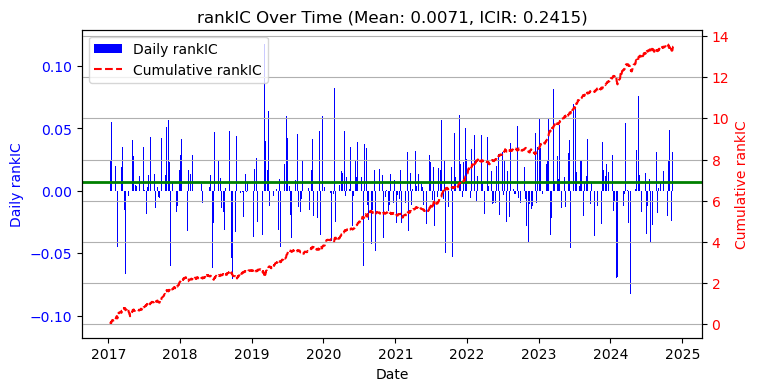

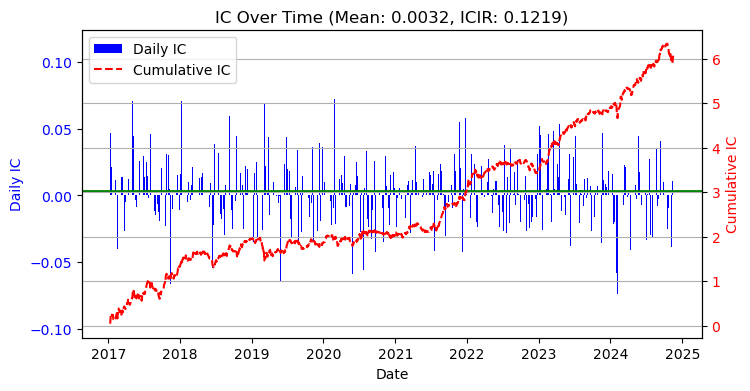

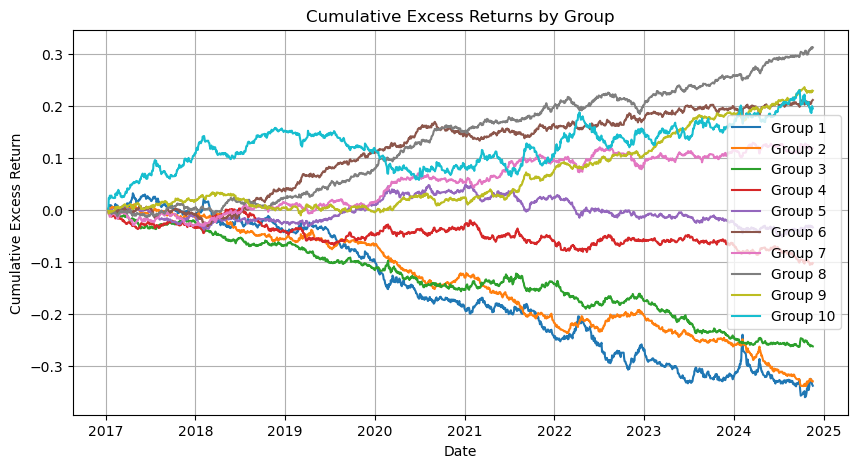

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.092909,-0.044259,-2.222892,-1.061905,0.162168
1,-0.162788,-0.043155,-6.098148,-1.646102,0.398776
2,-0.199968,-0.034348,-7.738231,-1.354975,0.552068
3,-0.206061,-0.013385,-8.052925,-0.530707,0.642254
4,-0.209773,-0.004382,-8.324149,-0.176605,0.684635
5,-0.180603,0.027693,-6.924095,1.071583,0.694323
6,-0.184645,0.015525,-7.011018,0.594597,0.667233
7,-0.134425,0.040928,-5.541051,1.698790,0.584508
8,-0.096755,0.029996,-4.185687,1.302832,0.422503


In [27]:
dftemp = df.copy()

dftemp = neutralize_factors(dftemp, factors=  ['neu_sector_neu_zscore_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False,other='neu_DST_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_sector_neu_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_sector_neu_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_sector_neu_zscore_process'] = df1['neu_neu_sector_neu_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_sector_neu_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))
calculate_annual_metrics(pnl_result)

#### DST_ZSCORE  & RPE_zscore

Finish neutralize


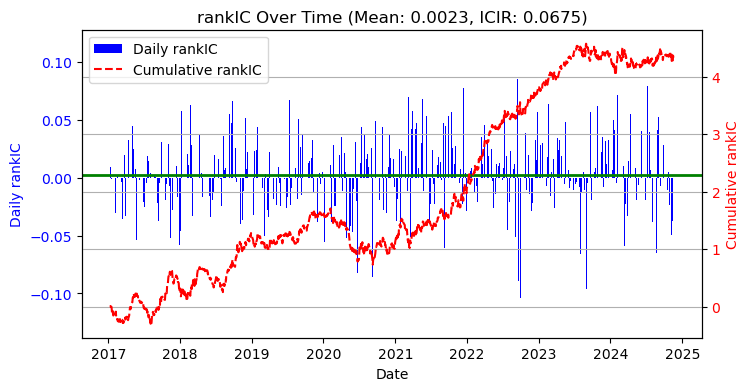

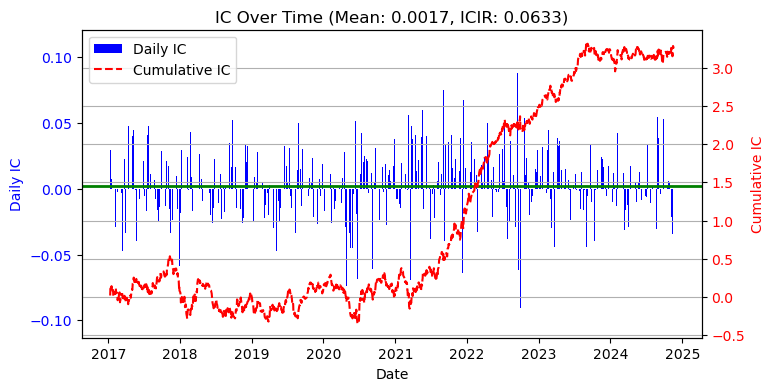

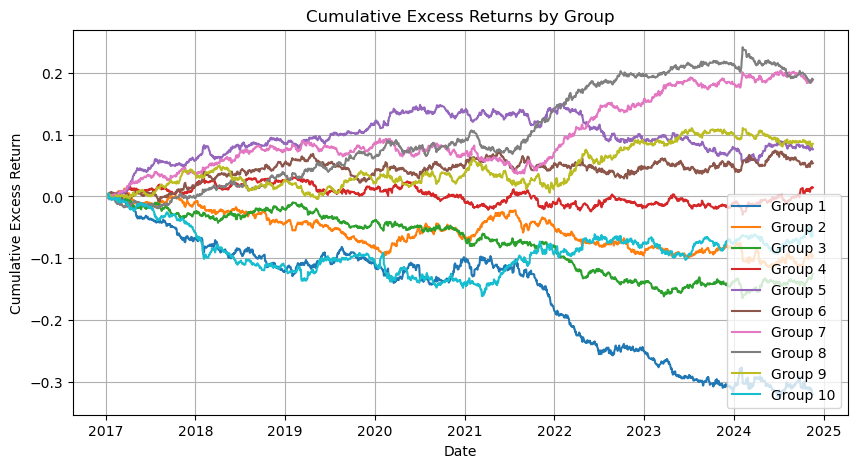

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.091005,-0.042061,-2.581301,-1.198360,0.163147
1,-0.130572,-0.012652,-4.664600,-0.458803,0.393067
2,-0.175452,-0.016502,-7.089139,-0.678433,0.529835
3,-0.181432,0.001892,-7.344059,0.077957,0.611079
4,-0.183300,0.010012,-6.984660,0.388134,0.644373
5,-0.184681,0.007052,-6.867622,0.267356,0.639111
6,-0.152824,0.024736,-5.960172,0.973600,0.591868
7,-0.127270,0.024844,-4.975382,0.981399,0.507048
8,-0.101791,0.011191,-3.631394,0.403114,0.376606


In [28]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_RPE_zscore_process'],process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_DST_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_RPE_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_RPE_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_RPE_zscore_process'] = df1['neu_neu_RPE_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_RPE_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

Finish neutralize


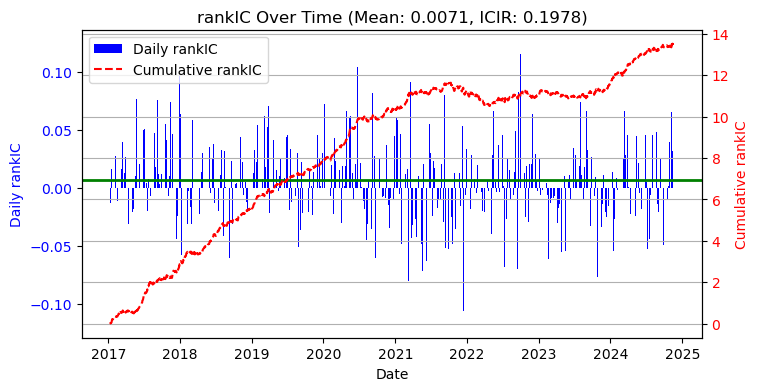

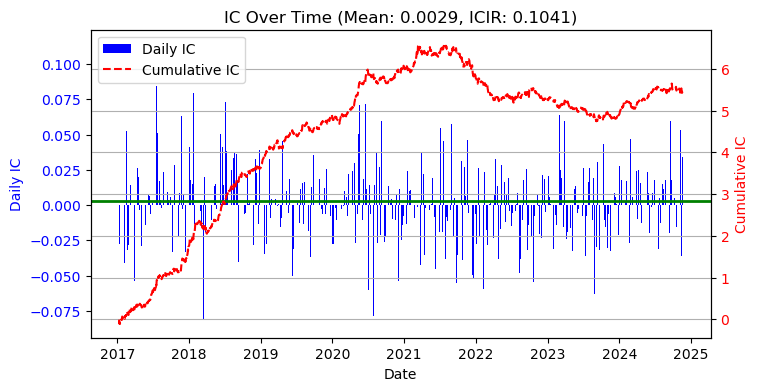

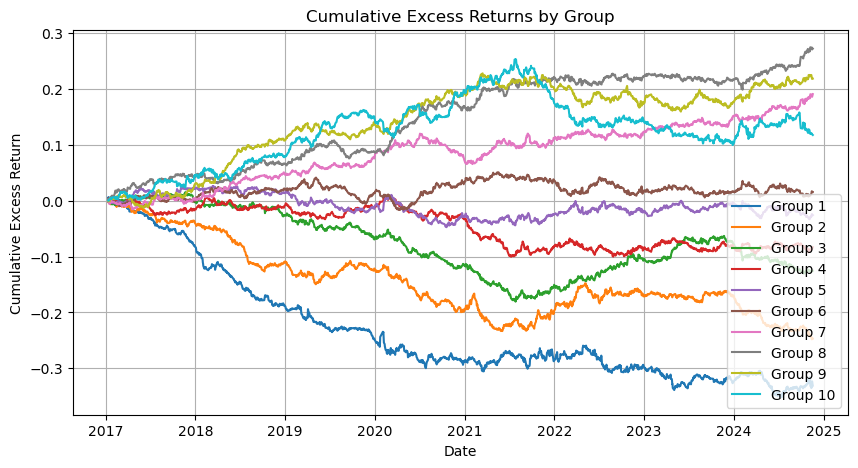

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.092233,-0.043431,-2.560035,-1.209344,0.162674
1,-0.147024,-0.032384,-4.803563,-1.066411,0.382133
2,-0.169909,-0.016467,-6.370143,-0.623452,0.511474
3,-0.188358,-0.010912,-7.508395,-0.443929,0.591485
4,-0.192632,-0.003393,-7.336973,-0.131348,0.630799
5,-0.190299,0.002025,-7.364776,0.080342,0.641079
6,-0.159004,0.025006,-6.329873,1.006117,0.613366
7,-0.125797,0.035693,-4.678652,1.346815,0.538300
8,-0.093130,0.028635,-3.183178,0.986813,0.405885


In [29]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_DST_zscore_process'], process=False,market_factor=False,momentum_factor=False, industry_factor=False, other='neu_RPE_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_DST_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_DST_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_DST_zscore_process'] = df1['neu_neu_DST_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_DST_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

#### RPE_zscore & SECTOR_neu

Finish neutralize


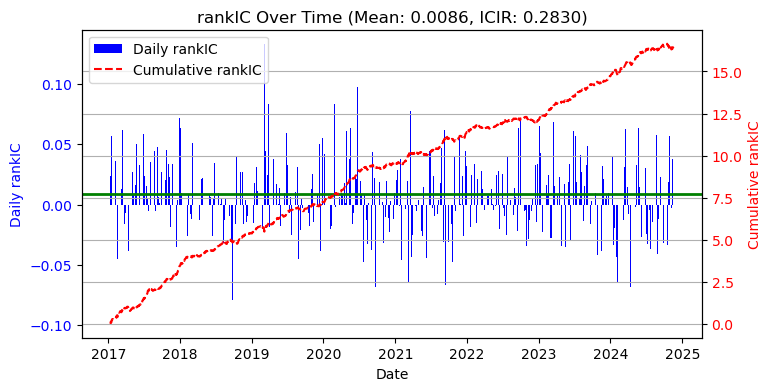

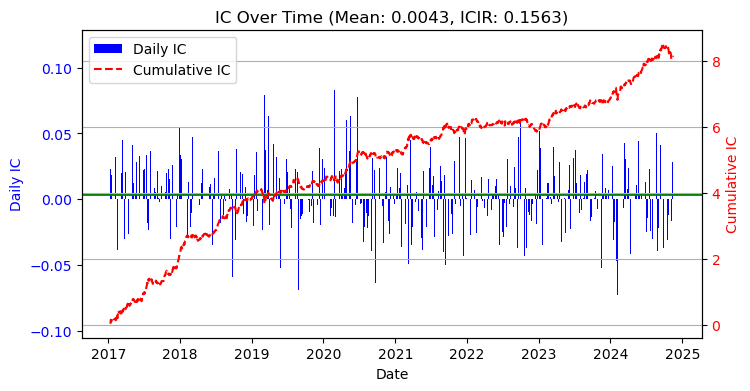

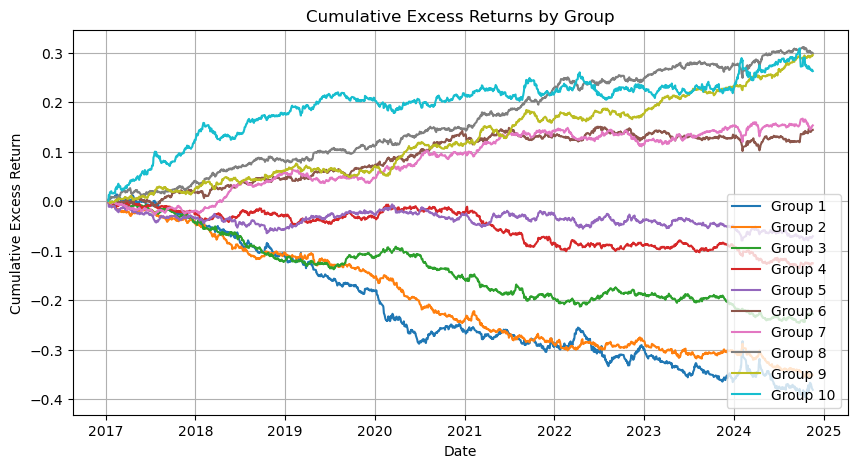

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.092947,-0.049970,-2.434109,-1.314110,0.143258
1,-0.146793,-0.046024,-5.363338,-1.711312,0.335897
2,-0.164785,-0.029825,-6.820756,-1.247908,0.449868
3,-0.171818,-0.016413,-7.232509,-0.699007,0.518019
4,-0.175162,-0.009235,-7.147418,-0.382114,0.553088
5,-0.148884,0.018941,-5.892502,0.755947,0.559415
6,-0.139845,0.020139,-5.604679,0.819027,0.533281
7,-0.101331,0.039232,-4.136512,1.613064,0.468541
8,-0.066943,0.038780,-2.811231,1.640391,0.352411


In [30]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=  ['neu_sector_neu_zscore_process'],process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_RPE_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_sector_neu_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_sector_neu_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_sector_neu_zscore_process'] = df1['neu_neu_sector_neu_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_sector_neu_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)

Finish neutralize


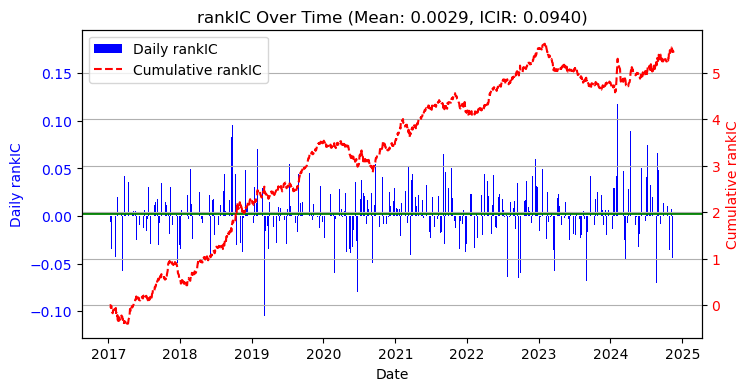

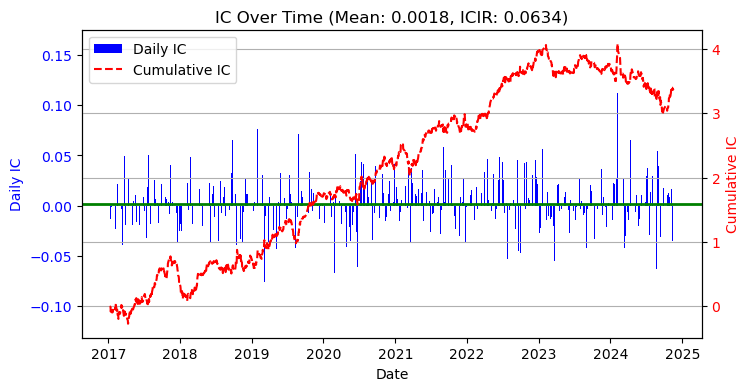

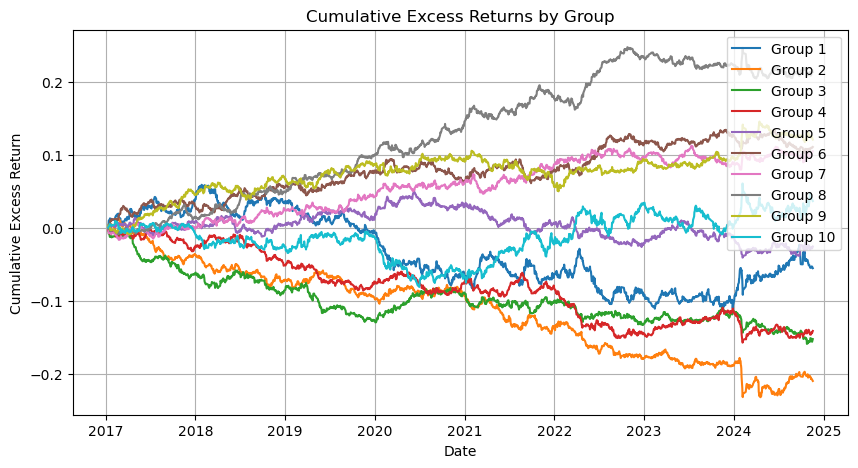

,net_excess_return,gross_excess_return,sharpe_net,sharpe_gross,turnover_rate
quantile,,,,,
0,-0.050091,-0.007255,-1.322399,-0.192528,0.142788
1,-0.129168,-0.027490,-4.987080,-1.069005,0.338926
2,-0.158550,-0.019980,-6.532181,-0.839594,0.461900
3,-0.180083,-0.018511,-7.582943,-0.791625,0.538573
4,-0.175605,-0.003371,-7.184106,-0.139295,0.574113
5,-0.156938,0.014491,-6.432935,0.604052,0.571431
6,-0.146601,0.013723,-6.080749,0.577840,0.534414
7,-0.110322,0.027949,-4.575484,1.170706,0.460903
8,-0.086081,0.015816,-3.432342,0.636080,0.339658


In [31]:
dftemp = df.copy()
dftemp = neutralize_factors(dftemp, factors=['neu_RPE_zscore_process'], process=False, market_factor=False,momentum_factor=False, industry_factor=False, other='neu_sector_neu_zscore_process')


calculate_and_plot_ic(dftemp, factor='neu_neu_RPE_zscore_process', ret='ret_daily', ic_type='both')

# 算benchmark
df1 = calculate_benchmark_return(dftemp, 'neu_neu_RPE_zscore_process', 'ret_overnight', 'ret_day', 'ret_daily')

df1['neu_neu_RPE_zscore_process'] = df1['neu_neu_RPE_zscore_process'].astype('float')

# 分组
df1['quantile'] = df1.groupby(['date'])['neu_neu_RPE_zscore_process'].transform(lambda x: pd.qcut(x,10,labels=False,duplicates='drop'))

pnl_result = get_pnl(df1)

plot_cumulative_returns(pnl_result.pivot(index='date', columns='quantile', values='cum_gross_excess'))

calculate_annual_metrics(pnl_result)